In [1]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import pandas as pd

import seaborn as sns
import torch
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

# Experiments set-up

In [3]:
experiment       = 'lucas'
abduction        = True
coeff_estimation = False

# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon, delta           = params.radius[experiment]
ll_num_envs, hl_num_envs = params.n_envs[experiment]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples, num_hlsamples  = params.n_samples[experiment]

# Load ground truth abstraction
Tau = mut.load_T(experiment)

In [4]:
Dll_obs  = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')
n_varsll = len(Gll.nodes())

Dhl_obs  = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')
n_varshl = len(Ghl.nodes())


omega    = mut.load_omega_map(experiment)

In [5]:
if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

In [6]:
# # [Not suggested] In case we want to explore also the interventional --> worse estimation!
# Dlls, Dhls = [], []
# for dpair in list(mut.load_samples(experiment).values()):
#     Dlls.append(dpair[0])
#     Dhls.append(dpair[1])
    
# ll_coeffs = mut.get_coefficients(Dlls, Gll)
# hl_coeffs = mut.get_coefficients(Dhls, Ghl) 

In [7]:
if abduction == True:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
else:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

In [8]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

# Optimization

In [9]:
def compute_grad_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L):

    sum_term     = torch.zeros_like(mu_L)
    for n, iota in enumerate(Ill):
        L_i   = torch.from_numpy(LLmodels[iota].F).float() 
        V_i   = T @ L_i  
        H_i   = torch.from_numpy(HLmodels[omega[iota]].F).float() 

        sum_term = sum_term + V_i.T @ V_i @ mu_L.float() - V_i.T @ H_i @ mu_H.float()
    
    reg_term     = 2 * lambda_L * (mu_L - hat_mu_L) # reg_term = -2 * lambda_L * (mu_L - hat_mu_L)
    grad_mu_L = (2 / (len(Ill))) * sum_term + reg_term

    return grad_mu_L

def compute_grad_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H):

    sum_term     = torch.zeros_like(mu_H)
    for n, iota in enumerate(Ill):
        L_i   = torch.from_numpy(LLmodels[iota].F).float()  
        V_i   = T @ L_i  
        H_i   = torch.from_numpy(HLmodels[omega[iota]].F).float()  

        sum_term = sum_term + H_i.T @ H_i @ mu_H.float() - (V_i.T @ H_i).T @ mu_L.float()
    
    reg_term     = 2 * lambda_H * (mu_H - hat_mu_H) # reg_term = -2 * lambda_H * (mu_H - hat_mu_H)
    grad_mu_H = (2 / len(Ill)) * sum_term + reg_term

    return grad_mu_H


def compute_grad_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L):

    sum_term         = torch.zeros_like(Sigma_L)
    for n, iota in enumerate(Ill):
        L_i          = torch.from_numpy(LLmodels[iota].F)
        V_i          = T @ L_i.float()

        sum_term        = sum_term + V_i.T @ V_i

    Sigma_L_sqrt     = oput.sqrtm_svd(Sigma_L)  
    hat_Sigma_L_sqrt = oput.sqrtm_svd(hat_Sigma_L) 

    reg_term         = 2 * lambda_L * (Sigma_L_sqrt - hat_Sigma_L_sqrt) @ torch.inverse(Sigma_L_sqrt) # reg_term = -2 * lambda_L * (Sigma_L_sqrt - hat_Sigma_L_sqrt) @ torch.inverse(Sigma_L_sqrt)
    grad_Sigma_L     = (2 / (n+1)) * sum_term + reg_term
    
    return grad_Sigma_L

def compute_grad_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H):

    sum_term            = torch.zeros_like(Sigma_H)
    for n, iota in enumerate(Ill):
        H_i          = torch.from_numpy(HLmodels[omega[iota]].F).float()
        
        sum_term     = sum_term + H_i.T @ H_i

    Sigma_H_sqrt     = oput.sqrtm_svd(Sigma_H)  
    hat_Sigma_H_sqrt = oput.sqrtm_svd(hat_Sigma_H) 

    reg_term            = 2 * lambda_H * (Sigma_H_sqrt - hat_Sigma_H_sqrt) @ torch.inverse(Sigma_H_sqrt) # reg_term = -2 * lambda_H * (Sigma_H_sqrt - hat_Sigma_H_sqrt) @ torch.inverse(Sigma_H_sqrt)
    grad_Sigma_H     = (2 / (n+1)) * sum_term + reg_term

    return grad_Sigma_H

def prox_grad_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param_L):

    Sigma_L               = torch.zeros_like(Sigma_L_half, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i               = torch.from_numpy(LLmodels[iota].F).float()  
        V_i               = oput.regmat(T @ L_i)  
        H_i               = torch.from_numpy(HLmodels[omega[iota]].F).float()  
        
        Sigma_L_half      = Sigma_L_half.float()
        V_Sigma_V         = V_i @ Sigma_L_half @ V_i.T
        sqrtm_V_Sigma_V   = oput.sqrtm_svd(oput.regmat(V_Sigma_V)) 
        
        prox_Sigma_L_half = oput.prox_operator(sqrtm_V_Sigma_V, lambda_param_L) @ oput.prox_operator(sqrtm_V_Sigma_V, lambda_param_L).T
        
        ll_term           = oput.regmat(torch.linalg.pinv(V_i)) @ oput.regmat(prox_Sigma_L_half) @ oput.regmat(torch.linalg.pinv(V_i).T)

        Sigma_H           = Sigma_H.float()  
        H_Sigma_H         = H_i @ Sigma_H @ H_i.T

        hl_term           = torch.norm(oput.sqrtm_svd(oput.regmat(H_Sigma_H)), p='fro') 

        Sigma_L           = Sigma_L + (ll_term * hl_term)

    Sigma_L_final         = (2 / (n+1)) * Sigma_L 
    Sigma_L_final         = oput.diagonalize(Sigma_L_final)

    return Sigma_L_final

def prox_grad_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param_H):

    Sigma_H               = torch.zeros_like(Sigma_H_half, dtype=torch.float32)
    for n, iota in enumerate(Ill):
        L_i               = torch.from_numpy(LLmodels[iota].F).float()
        V_i               = T @ L_i #oput.regmat(T @ L_i)
        H_i               = torch.from_numpy(HLmodels[omega[iota]].F).float()

        Sigma_H_half      = Sigma_H_half.float()
        H_Sigma_H         = H_i @ Sigma_H_half @ H_i.T
        sqrtm_H_Sigma_H   = oput.sqrtm_svd(H_Sigma_H)
        #H_Sigma_H         = oput.regmat(H_i @ Sigma_H_half @ H_i.T)
  
        prox_Sigma_H_half = oput.prox_operator(sqrtm_H_Sigma_H, lambda_param_H) @ oput.prox_operator(sqrtm_H_Sigma_H, lambda_param_H).T
        hl_term_iota      = torch.inverse(H_i) @ prox_Sigma_H_half @ torch.inverse(H_i).T
        
        Sigma_L           = Sigma_L.float()
        V_Sigma_V         = V_i @ Sigma_L @ V_i.T
        ll_term_iota      = torch.norm(oput.sqrtm_svd(V_Sigma_V), p='fro')

        Sigma_H           = Sigma_H + (ll_term_iota * hl_term_iota)
    
    Sigma_H_final         = (2 / (n+1)) * Sigma_H
    Sigma_H_final         = oput.diagonalize(Sigma_H_final)
    
    return Sigma_H_final

In [10]:
def optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta, num_steps_min, optimizer_T, max_grad_norm, seed, xavier):

    torch.manual_seed(seed)
    if xavier:
        T = torch.nn.init.xavier_normal_(T, gain=0.01)

    cur_mu_L    = mu_L.clone()
    cur_mu_H    = mu_H.clone()
    cur_Sigma_L = Sigma_L.clone()
    cur_Sigma_H = Sigma_H.clone()

    objective_T_step = torch.tensor(0.0)  
    T_objectives_epoch = []
   
    for step in range(num_steps_min):

        objective_iota = torch.tensor(0.0)        
        for n, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota].F).float()
            H_i = torch.from_numpy(HLmodels[omega[iota]].F).float()
            
            obj_value_iota   = oput.compute_objective_value(T, L_i, H_i, cur_mu_L, cur_mu_H, cur_Sigma_L, cur_Sigma_H,
                                                            lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta)
            
            objective_iota = objective_iota + obj_value_iota

        objective_T_step = objective_iota/(n+1)
        T_objectives_epoch.append(objective_T_step)

        if torch.isnan(T).any():
            print("T contains NaN! Returning zero matrix.")
            print('Failed at step:', step+1)
            # Return zero matrix of same shape as T
            return torch.zeros_like(T).detach().requires_grad_(True), objective_T_step, T_objectives_epoch

        optimizer_T.zero_grad() 
        objective_T_step.backward(retain_graph=True)
        # Add gradient clipping before optimizer step
        if max_grad_norm < float('inf'):
            torch.nn.utils.clip_grad_norm_([T], max_grad_norm)

        optimizer_T.step()  
        #print(f"Min step {step+1}/{num_steps_min}, Objective: {objective_T_step.item()}, Gradient Norm: {torch.norm(T.grad)}")
    
    return T, objective_T_step, T_objectives_epoch


def optimize_max(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                 lambda_L, lambda_H, lambda_param_L, lambda_param_H, eta, num_steps_max, epsilon, delta, seed, project_onto_gelbrich, max_grad_norm):
    
    torch.manual_seed(seed)

    cur_T = T.clone()
    theta_objectives_epoch = []
    objective_theta_step = torch.tensor(0.0)
    
    max_converged = False
    # Pre-compute constant terms
    L_matrices = {iota: torch.from_numpy(LLmodels[iota].F).float() for iota in Ill}
    H_matrices = {iota: torch.from_numpy(HLmodels[omega[iota]].F).float() for iota in Ill}
        
    # Initialize running averages for adaptive learning rate
    avg_grad_norm = 0
    beta = 0.9  # momentum factor
    
    for step in range(num_steps_max): 
        # Compute all gradients first
        grad_mu_L = compute_grad_mu_L(cur_T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L)
        grad_mu_H = compute_grad_mu_H(cur_T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H)
        grad_Sigma_L = compute_grad_Sigma_L_half(cur_T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L)
        grad_Sigma_H = compute_grad_Sigma_H_half(cur_T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H)

        # Clip gradients
        if max_grad_norm < float('inf'):
            grad_mu_L = torch.clamp(grad_mu_L, -max_grad_norm, max_grad_norm)
            grad_mu_H = torch.clamp(grad_mu_H, -max_grad_norm, max_grad_norm)
            grad_Sigma_L = torch.clamp(grad_Sigma_L, -max_grad_norm, max_grad_norm)
            grad_Sigma_H = torch.clamp(grad_Sigma_H, -max_grad_norm, max_grad_norm)

        # Compute current gradient norm
        current_grad_norm = (torch.norm(grad_mu_L) + torch.norm(grad_mu_H) + 
                           torch.norm(grad_Sigma_L) + torch.norm(grad_Sigma_H))
        
        # Update running average
        avg_grad_norm = beta * avg_grad_norm + (1 - beta) * current_grad_norm
        
        # Adjust learning rate if gradients are getting too large
        current_eta = eta
        if avg_grad_norm > 1.0:
            current_eta = eta / avg_grad_norm

        # Update parameters
        mu_L = mu_L + current_eta * grad_mu_L
        mu_H = mu_H + current_eta * grad_mu_H
        
        Sigma_L_half = Sigma_L + current_eta * grad_Sigma_L
        Sigma_H_half = Sigma_H + current_eta * grad_Sigma_H
        
        # Proximal updates
        Sigma_L = prox_grad_Sigma_L(cur_T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param_L)
        Sigma_H = prox_grad_Sigma_H(cur_T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param_H)
        
        if project_onto_gelbrich:
            mu_L, Sigma_L = oput.project_onto_gelbrich_ball(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
            mu_H, Sigma_H = oput.project_onto_gelbrich_ball(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
            
            satisfied_L, dist_L, epsi = oput.verify_gelbrich_constraint(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
            satisfied_H, dist_H, delt = oput.verify_gelbrich_constraint(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
            
            oput.constraints_error_check(satisfied_L, dist_L, epsi, satisfied_H, dist_H, delt)

        objective_iota = 0
        for iota in Ill:
            obj_value_iota = oput.compute_objective_value(
                                                            cur_T, L_matrices[iota], H_matrices[iota], 
                                                            mu_L, mu_H, Sigma_L, Sigma_H,
                                                            lambda_L, lambda_H, hat_mu_L, hat_mu_H, 
                                                            hat_Sigma_L, hat_Sigma_H, epsilon, delta
                                                         )
            objective_iota += obj_value_iota

        objective_theta_step = objective_iota/len(Ill)
        theta_objectives_epoch.append(objective_theta_step)

        # Early stopping check
        if step > 0 and abs(theta_objectives_epoch[-1] - theta_objectives_epoch[-2]) < 1e-5:
            max_converged = True

    return mu_L, Sigma_L, mu_H, Sigma_H, objective_theta_step, theta_objectives_epoch, max_converged

def optimize_max_proxgrad(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, 
                lambda_L, lambda_H, lambda_param_L, lambda_param_H, eta, num_steps_max, epsilon, delta, seed):

    torch.manual_seed(seed)
    cur_T   = T.clone()

    mu_L    = mu_L.clone().detach().requires_grad_(True)
    mu_H    = mu_H.clone().detach().requires_grad_(True)
    Sigma_L = Sigma_L.clone().detach().requires_grad_(True)
    Sigma_H = Sigma_H.clone().detach().requires_grad_(True)

    max_converged = False
    
    # Create optimizers for means and covariances
    optimizer_mu    = torch.optim.Adam([mu_L, mu_H], lr=eta)
    optimizer_sigma = torch.optim.Adam([Sigma_L, Sigma_H], lr=eta)
    
    theta_objectives_epoch = []
    
    for step in range(num_steps_max):
        # Zero gradients
        optimizer_mu.zero_grad()
        optimizer_sigma.zero_grad()
        
        # Compute objective for this step
        obj_values = []
        for n, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota].F).float()
            H_i = torch.from_numpy(HLmodels[omega[iota]].F).float()
            
            # Compute objective value
            obj_value_iota = oput.compute_objective_value(cur_T, L_i, H_i, mu_L, mu_H, Sigma_L, Sigma_H, 
                                                            lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta)
            obj_values.append(obj_value_iota)
        
        # Sum objectives without in-place operations
        objective_iota = torch.stack(obj_values).sum()
        # Total objective
        objective = -(objective_iota/(n+1))
        
        # Store objective value
        theta_objectives_epoch.append(-objective.item())
        
        # Early stopping check
        if step > 0 and abs(theta_objectives_epoch[-1] - theta_objectives_epoch[-2]) < 1e-5:
            max_converged = True

        # Backward pass
        objective.backward()
        
        # Update means using optimizer
        optimizer_mu.step()
        
        # Store current Sigma values before proximal update
        Sigma_L_half = Sigma_L.detach().clone()
        Sigma_H_half = Sigma_H.detach().clone()
        
        # Update Sigma_half values using optimizer
        optimizer_sigma.step()
        
        # Manual proximal gradient steps for Sigma_L and Sigma_H
        with torch.no_grad():
            # Proximal step for Sigma_L
            Sigma_L = prox_grad_Sigma_L(cur_T, Sigma_L_half, LLmodels, Sigma_H_half, HLmodels, lambda_param_L)
            
            # Proximal step for Sigma_H
            Sigma_H = prox_grad_Sigma_H(cur_T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param_H)
            
            # Update the tensor values for next iteration
            Sigma_L.requires_grad_(True)
            Sigma_H.requires_grad_(True)

    return (mu_L.detach(), Sigma_L.detach(), mu_H.detach(), Sigma_H.detach(), objective.detach(), theta_objectives_epoch, max_converged)

In [11]:
def run_erica_optimization(theta_hatL, theta_hatH, initial_theta,
                     epsilon, delta, lambda_L, lambda_H, lambda_param_L, lambda_param_H, 
                     xavier, project_onto_gelbrich, eta_min, eta_max, max_iter, num_steps_min, num_steps_max, proximal_grad,
                     tol, seed, robust_L, robust_H, grad_clip, plot_steps, plot_epochs, display_results):
    
    torch.manual_seed(seed) 

    # Start timing
    start_time = time.time()

    if not robust_L:
        epsilon = 0
    if not robust_H:
        delta = 0

    erica = robust_L or robust_H

    if not erica:
        num_steps_min = 1
    
    if grad_clip:
        max_grad_norm = 1.0
    else:
        max_grad_norm = float('inf')
    
    if xavier and not project_onto_gelbrich:
        print("Forcing projection onto Gelbrich ball!")
        project_onto_gelbrich = True
    
    max_converged = False
    
    mu_L, Sigma_L, mu_H, Sigma_H, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H = oput.get_initialization(theta_hatL, theta_hatH, epsilon, delta, initial_theta)

    T           = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)
    optimizer_T = torch.optim.Adam([T], lr=eta_min, eps=1e-8, amsgrad=True)
    condition_num_list = []
    condition_num_list.append(evut.condition_number(T.detach().numpy()))
    previous_objective = float('inf') 
    epoch_objectives   = {'T_objectives_overall': [], 'theta_objectives_overall': []}
    for epoch in tqdm(range(max_iter)): 
        
        inner_loop_objectives = {'min_objectives': [], 'max_objectives': []}
        
        # Minimize T
        T_new, objective_T, T_objectives_epoch = optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                                                              lambda_L, lambda_H, hat_mu_L, hat_mu_H, hat_Sigma_L, hat_Sigma_H,
                                                            epsilon, delta, num_steps_min, optimizer_T, max_grad_norm, seed, xavier=xavier)

        #condition_num_list.append(evut.condition_number(T_new.detach().numpy()))
        inner_loop_objectives['min_objectives'] = T_objectives_epoch
        epoch_objectives['T_objectives_overall'].append(objective_T)

        # Maximize μ, Σ
        if erica and not max_converged:  
            if proximal_grad:
                mu_L, Sigma_L, mu_H, Sigma_H, obj_theta, theta_objectives_epoch, max_converged = optimize_max_proxgrad(T_new, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                                                                                                        hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                                                                                        lambda_L, lambda_H, lambda_param_L, lambda_param_H,
                                                                                                        eta_max, num_steps_max, epsilon, delta, seed
                                                                                                        )
            else:
                mu_L, Sigma_L, mu_H, Sigma_H, obj_theta, theta_objectives_epoch, max_converged = optimize_max(
                                                                                                T_new, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                                                                                                hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                                                                                lambda_L, lambda_H, lambda_param_L, lambda_param_H,
                                                                                                eta_max, num_steps_max, epsilon, delta, seed, project_onto_gelbrich, max_grad_norm
                                                                                              )
            
            if max_converged:
                num_steps_min = 1
                print(f"Max converged at epoch {epoch+1}")
            # Store objectives
            inner_loop_objectives['max_objectives'] = theta_objectives_epoch
            epoch_objectives['theta_objectives_overall'].append(obj_theta)
    
        if plot_steps:
            oput.plot_inner_loop_objectives(inner_loop_objectives, epoch, erica)
        
        # Check convergence
        criterion = abs(previous_objective - objective_T.item()) 
        if criterion < tol:
            print(f"Convergence reached at epoch {epoch+1} with objective {objective_T.item()}")
            break
        
        
        T                  = T_new
        previous_objective = objective_T.item()

    if plot_epochs:
        oput.plot_epoch_objectives(epoch_objectives, erica)

    paramsL      = {'mu_U': mu_L.detach().numpy(), 'Sigma_U': Sigma_L.detach().numpy(), 'radius': epsilon}
    paramsH      = {'mu_U': mu_H.detach().numpy(), 'Sigma_U': Sigma_H.detach().numpy(), 'radius': delta}
    T            = T.detach().numpy()
    end_time     = time.time()
    elapsed_time = end_time - start_time

    if display_results == True:
        oput.print_results(T, paramsL, paramsH, elapsed_time)

    return paramsL, paramsH, T, inner_loop_objectives, epoch_objectives, condition_num_list

In [16]:
theta_hatL   = {'mu_U': mu_U_ll_hat, 'Sigma_U': Sigma_U_ll_hat, 'radius': epsilon}
theta_hatH   = {'mu_U': mu_U_hl_hat, 'Sigma_U': Sigma_U_hl_hat, 'radius': delta}

epsilon = 2
delta   = 2

lambda_L = .6 #.9 

lambda_H = .3 #.9 

lambda_param_L = .2 #.3 
lambda_param_H = .1 #.3

xavier = False
project_onto_gelbrich = True

eta_max = 0.001
eta_min = 0.001

max_iter = 100
num_steps_min = 5
num_steps_max = 2

robust_L = True
robust_H = True

proximal_grad = False

tol = 1e-4
grad_clip = True

seed = 23

plot_steps = False
plot_epochs = False
display_results = False

In [17]:
params_erica =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': epsilon,
                    'delta': delta,
                    'lambda_L': lambda_L,
                    'lambda_H': lambda_H,
                    'lambda_param_L': lambda_param_L,
                    'lambda_param_H': lambda_param_H,
                    'xavier': xavier, 
                    'project_onto_gelbrich': project_onto_gelbrich, 
                    'eta_max': eta_max,
                    'eta_min': eta_min,
                    'max_iter': max_iter,
                    'num_steps_min': num_steps_min,
                    'num_steps_max': num_steps_max,
                    'proximal_grad': proximal_grad,
                    'tol': tol,
                    'seed': seed,
                    'robust_L': robust_L,
                    'robust_H': robust_H,
                    'grad_clip': grad_clip,
                    'plot_steps': plot_steps,
                    'plot_epochs': plot_epochs,
                    'display_results': display_results
                }

## ERiCA optimization

### a. Manual

In [15]:
params_Lerica, params_Herica, T_erica, inobjs, epobjs, condition_num_list = run_erica_optimization(**params_erica)

100%|██████████| 10/10 [00:22<00:00,  2.23s/it]


In [14]:
type_to_params = {
                     'gelbrich_gaussian': {
                           'L': theta_hatL,
                           'H': theta_hatH
                     },
                     
                     'boundary_gaussian': {
                           'L': params_Lerica,
                           'H': params_Herica
                     },

                     'rand_epsilon_delta': {
                           'L': params_Lerica,
                           'H': params_Herica
                     }
                 }


joblib.dump(type_to_params, f"data/{experiment}/type_to_params.pkl")

['data/synth1/type_to_params.pkl']

In [133]:
# params_erica =  {
#                     'theta_hatL': theta_hatL,
#                     'theta_hatH': theta_hatH,
#                     'initial_theta': 'random',
#                     'epsilon': epsilon,
#                     'delta': delta,
#                     'lambda_L': .9,
#                     'lambda_H': .9,
#                     'lambda_param_L': .3, # when high monotonic increase for seed 42
#                     'lambda_param_H': .3,
#                     'eta_max': 0.001,
#                     'eta_min': 0.0001,
#                     'max_iter': 10,
#                     'num_steps_min': 5,
#                     'num_steps_max': 4,
#                     'proximal_grad': False,
#                     'tol': 1e-5,
#                     'seed': seed,
#                     'robust_L': True,
#                     'robust_H': True,
#                     'plot_steps': False,
#                     'plot_epochs': False,
#                     'display_results': True
#                 }

# params_Lerica, params_Herica, T_erica, inobjs, epobjs, condition_num_list = run_optimization(**params_erica)

### b. ProxGrad

In [18]:
params_Lerica, params_Herica, T_erica_prox, inobjs_prox, epobjs_prox, condition_num_list_prox = run_erica_optimization(**{**params_erica, 'proximal_grad': True})

100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


In [19]:
type_to_params = {
                     'gelbrich_gaussian': {
                           'L': theta_hatL,
                           'H': theta_hatH
                     },
                     
                     'boundary_gaussian': {
                           'L': params_Lerica,
                           'H': params_Herica
                     },

                     'rand_epsilon_delta': {
                           'L': params_Lerica,
                           'H': params_Herica
                     }
                 }

joblib.dump(type_to_params, f"data/{experiment}/type_to_params.pkl")

['data/lucas/type_to_params.pkl']

### 2. ENRiCO optimization

In [20]:

# Non-robust (no robust_L or robust_H)
params_Lenrico, params_Henrico, T_enrico, inobjs, epobjs, condition_num_list = run_erica_optimization(**{**params_erica, 'robust_L': False, 'robust_H': False})

100%|██████████| 100/100 [00:03<00:00, 29.83it/s]


## 3. Barycentric optimization

In [21]:
L_models = LLmodels
H_models = HLmodels
Ill = Ill
Ihl = Ihl
projection_method = 'svd'
initialization = 'avg'
autograd = False
seed = seed
max_iter = max_iter
tol = tol
display_results = False


In [22]:
params_bary =  {
                'theta_L': theta_hatL,
                'theta_H': theta_hatH,
                'LLmodels': LLmodels,
                'HLmodels': HLmodels,
                'Ill': Ill,
                'Ihl': Ihl,
                'projection_method': projection_method,
                'initialization': initialization,
                'autograd': autograd,
                'seed': seed,
                'max_iter': max_iter,
                'tol': tol,
                'display_results': display_results
                }

### a.  Monge

In [23]:

params_Lbary, params_Hbary, T_bary = oput.barycentric_optimization(**params_bary)

### b.  Autograd

In [24]:

params_Lbary, params_Hbary, T_bary_auto = oput.barycentric_optimization(**{**params_bary, 'autograd': True})

In [25]:
joblib.dump(T_erica, f"data/{experiment}/T_erica.pkl")
joblib.dump(T_erica_prox, f"data/{experiment}/T_erica_prox.pkl")
joblib.dump(T_enrico, f"data/{experiment}/T_enrico.pkl")
joblib.dump(T_bary, f"data/{experiment}/T_bary.pkl")
joblib.dump(T_bary_auto, f"data/{experiment}/T_bary_auto.pkl")
joblib.dump(Tau, f"data/{experiment}/Tau.pkl")

['data/lucas/Tau.pkl']

# Evaluation

### Condition number comparison

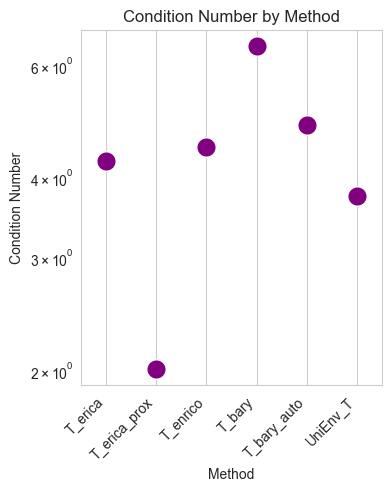

In [26]:
T_name         = ['T_erica','T_erica_prox', 'T_enrico', 'T_bary', 'T_bary_auto', 'UniEnv_T']
condition_nums = {}
for i, T in enumerate([T_erica, T_erica_prox, T_enrico, T_bary, T_bary_auto, Tau]): 
    cn = evut.condition_number(T)
    condition_nums[T_name[i]] = cn
    #print(f"For {T_name[i]} method condition number of final T = {cn}")
evut.plot_condition_nums(condition_nums)

In [27]:
data = mut.load_samples(experiment)

In [28]:
add_noiseL         = True
add_noiseH         = True
noise_typeL        = 'boundary_gaussian'
noise_typeH        = 'boundary_gaussian'

lin_contaminationL = False
lin_contaminationH = False
cont_type          = 'multiplicative'
cont_fracL         = .9
cont_fracH         = .6

metric             = 'wass'
num_iter           = 10

if noise_typeL == 'random_normal' or noise_typeH == 'random_normal':
    noise_range = (0, 1)
else:
    noise_range = None


In [29]:
methods      = ['T_erica', 'T_erica_prox', 'T_enrico', 'T_bary', 'T_bary_auto', 'Tau']
abstraction_error = {name: [] for name in methods}

# Outer loop: number of noise sampling iterations
for iter_num in tqdm(range(num_iter)): # desc="Noise sampling iterations"
    
    noiseL = evut.generate_noise(data[None][0], noise_typeL, 'L', experiment, normalize=False, random_range=noise_range)#, rad=100)
    noiseH = evut.generate_noise(data[None][1], noise_typeH, 'H', experiment, normalize=False, random_range=noise_range)#, rad=100)
    
    for i, method in enumerate(methods):

        T     = mut.load_abstraction(experiment, method)
        total = 0
    
        # Compute average error over Ill for this method
        for iota in Ill:
            # Get base data and add noise
            base, abst = data[iota]
            
            if add_noiseL:
                base = base + noiseL # + base 
            if add_noiseH:
                abst = abst + noiseH # + abst
                
            if lin_contaminationL:
                base = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
            if lin_contaminationH:
                abst = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
            
            total += evut.compute_abstraction_error(T, base, abst, metric)
                        
        iter_avg = total / len(Ill)
        abstraction_error[methods[i]].append(iter_avg)

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Average e(τ) for T_erica: 75.73 ± 0.116

Average e(τ) for T_erica_prox: 47.67 ± 0.105

Average e(τ) for T_enrico: 76.79 ± 0.106

Average e(τ) for T_bary: 53.33 ± 0.159

Average e(τ) for T_bary_auto: 77.96 ± 0.117

Average e(τ) for Tau: 98.24 ± 0.286



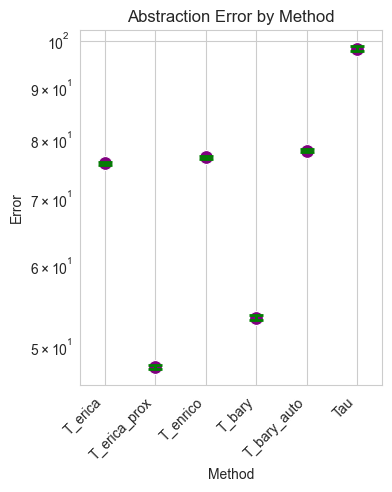

In [30]:
# Compute final statistics
final_abstraction_error = {}
for method in methods:
    mean_e = np.mean(abstraction_error[method])
    std_e = np.std(abstraction_error[method])
    final_abstraction_error[method] = (mean_e, std_e * 1.96)
    print(f"Average e(τ) for {method}: {mean_e:.2f} ± {std_e:.3f}\n")

# Plot results
evut.plot_abstraction_error(final_abstraction_error)

In [27]:
print('FINISHED')

FINISHED


In [31]:
# Define parameter grids
param_grid = {
                'num_steps_min': [1, 2, 3, 5],
                'num_steps_max': [1, 2, 3]
            }

# Create all combinations of parameters
from itertools import product
param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# Store results
results = []

# Run grid search
for params in tqdm(param_combinations):
    print(f"\nTesting parameters: {params}")
    
    # Update params_erica with current parameter combination
    current_params = {
        'theta_hatL': theta_hatL,
        'theta_hatH': theta_hatH,
        'initial_theta': 'empirical',
        'epsilon': epsilon,
        'delta': delta,
        'lambda_L': lambda_L,
        'lambda_H': lambda_H,
        'lambda_param_L': lambda_param_L,
        'lambda_param_H': lambda_param_H,
        'xavier': xavier,
        'project_onto_gelbrich': project_onto_gelbrich,
        'eta_max': eta_max,
        'eta_min': eta_min,
        'max_iter': max_iter,
        'proximal_grad': True,
        'tol': tol,
        'seed': seed,
        'robust_L': robust_L,
        'robust_H': robust_H,
        'grad_clip': grad_clip,
        'plot_steps': False,  # Disable plotting during grid search
        'plot_epochs': False,
        'display_results': False,
        **params  # Add the current parameter combination
    }
    
    # Run optimization
    params_Lerica, params_Herica, T_erica, inobjs, epobjs, condition_num_list = run_erica_optimization(**current_params)
    
    # Evaluate current parameters
    abstraction_error = []
    for _ in range(num_iter):
        noiseL = evut.generate_noise(data[None][0], noise_typeL, 'L', experiment, normalize=False, random_range=noise_range)
        noiseH = evut.generate_noise(data[None][1], noise_typeH, 'H', experiment, normalize=False, random_range=noise_range)
        
        total = 0
        for iota in Ill:
            base, abst = data[iota]
            
            if add_noiseL:
                base = base + noiseL
            if add_noiseH:
                abst = abst + noiseH
                
            total += evut.compute_abstraction_error(T_erica, base, abst, metric)
                        
        iter_avg = total / len(Ill)
        abstraction_error.append(iter_avg)
    
    mean_error = np.mean(abstraction_error)
    std_error = np.std(abstraction_error)
    
    # Store results
    results.append({
        'parameters': params,
        'mean_error': mean_error,
        'std_error': std_error,
        'condition_number': evut.condition_number(T_erica)
    })
    
    print(f"Mean error: {mean_error:.4f} ± {std_error*1.96:.4f}")

# Find best parameters
best_result = min(results, key=lambda x: x['mean_error'])
print("\nBest parameters:")
print(f"Parameters: {best_result['parameters']}")
print(f"Mean error: {best_result['mean_error']:.4f} ± {best_result['std_error']*1.96:.4f}")
print(f"Condition number: {best_result['condition_number']:.4f}")

# # Optional: Save results to file
# import json
# with open(f"data/{experiment}/grid_search_results.json", 'w') as f:
#     json.dump(results, f, indent=2)

  0%|          | 0/12 [00:00<?, ?it/s]


Testing parameters: {'num_steps_min': 1, 'num_steps_max': 1}


  8%|▊         | 1/12 [00:14<02:40, 14.59s/it]

Mean error: 73.0187 ± 0.3557

Testing parameters: {'num_steps_min': 1, 'num_steps_max': 2}


 16%|█▌        | 16/100 [00:03<00:16,  5.11it/s]


Convergence reached at epoch 17 with objective 29.57343101501465


 17%|█▋        | 2/12 [00:19<01:31,  9.13s/it]

Mean error: 77.5308 ± 0.3184

Testing parameters: {'num_steps_min': 1, 'num_steps_max': 3}


 25%|██▌       | 3/12 [00:48<02:42, 18.08s/it]

Mean error: 72.5249 ± 0.2362

Testing parameters: {'num_steps_min': 2, 'num_steps_max': 1}


 33%|███▎      | 4/12 [01:06<02:24, 18.06s/it]

Mean error: 64.8527 ± 0.2142

Testing parameters: {'num_steps_min': 2, 'num_steps_max': 2}


 42%|████▏     | 5/12 [01:30<02:21, 20.27s/it]

Mean error: 64.3152 ± 0.2276

Testing parameters: {'num_steps_min': 2, 'num_steps_max': 3}


 50%|█████     | 6/12 [02:00<02:21, 23.51s/it]

Mean error: 64.4425 ± 0.2174

Testing parameters: {'num_steps_min': 3, 'num_steps_max': 1}


 58%|█████▊    | 7/12 [02:19<01:50, 22.11s/it]

Mean error: 56.5597 ± 0.2005

Testing parameters: {'num_steps_min': 3, 'num_steps_max': 2}


 67%|██████▋   | 8/12 [02:46<01:34, 23.53s/it]

Mean error: 56.4383 ± 0.3139

Testing parameters: {'num_steps_min': 3, 'num_steps_max': 3}


 75%|███████▌  | 9/12 [03:22<01:22, 27.51s/it]

Mean error: 57.1839 ± 0.2447

Testing parameters: {'num_steps_min': 5, 'num_steps_max': 1}


 83%|████████▎ | 10/12 [03:51<00:55, 27.92s/it]

Mean error: 46.1203 ± 0.2787

Testing parameters: {'num_steps_min': 5, 'num_steps_max': 2}


 92%|█████████▏| 11/12 [04:27<00:30, 30.25s/it]

Mean error: 47.6911 ± 0.2266

Testing parameters: {'num_steps_min': 5, 'num_steps_max': 3}


100%|██████████| 12/12 [05:06<00:00, 25.57s/it]

Mean error: 48.8943 ± 0.1780

Best parameters:
Parameters: {'num_steps_min': 5, 'num_steps_max': 1}
Mean error: 46.1203 ± 0.2787
Condition number: 1.9424


In [ ]:
import json
with open(f"data/{experiment}/grid_search_results.json", 'w') as f:
    json.dump(results, f, indent=2)

In [34]:
best_result = min(results, key=lambda x: x['mean_error'])
print("\nBest parameters:")
print(f"Parameters: {best_result['parameters']}")
print(f"Mean error: {best_result['mean_error']:.4f} ± {best_result['std_error']*1.96:.4f}")
print(f"Condition number: {best_result['condition_number']:.4f}")


Best parameters:
Parameters: {'lambda_L': 0.6, 'lambda_H': 0.3, 'lambda_param_L': 0.2, 'lambda_param_H': 0.1}
Mean error: 3.8279 ± 0.3984
Condition number: 2.4881


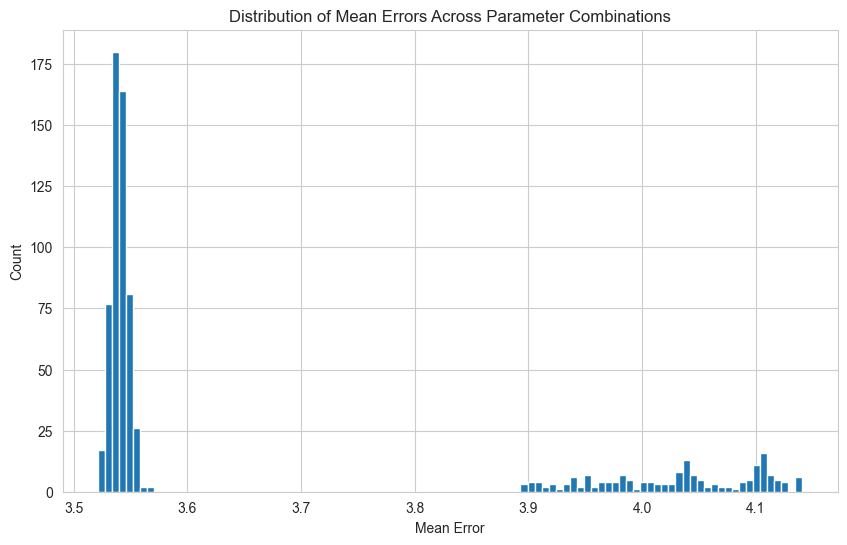

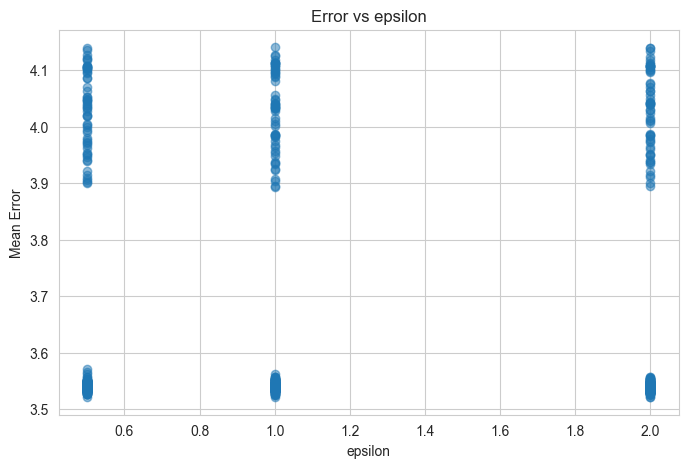

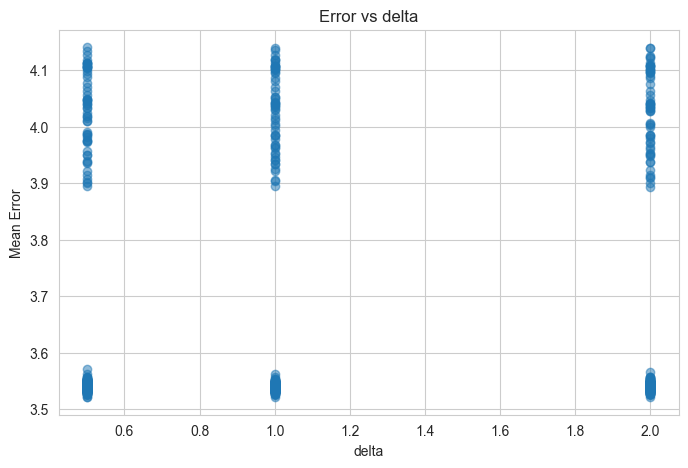

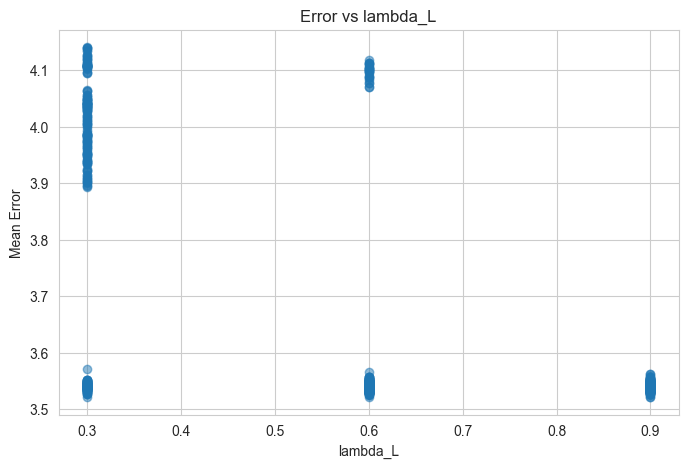

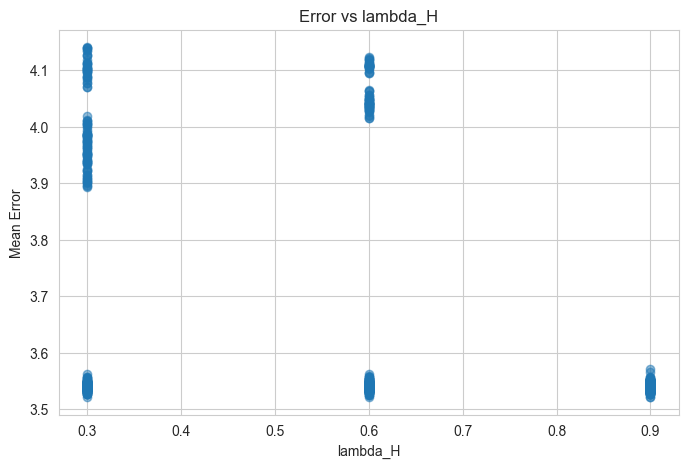

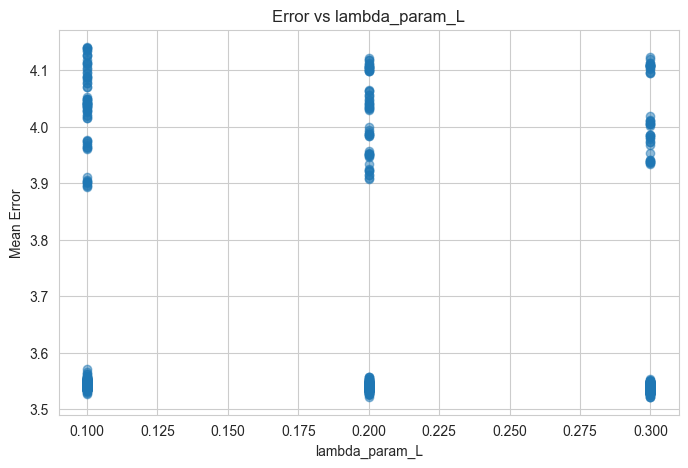

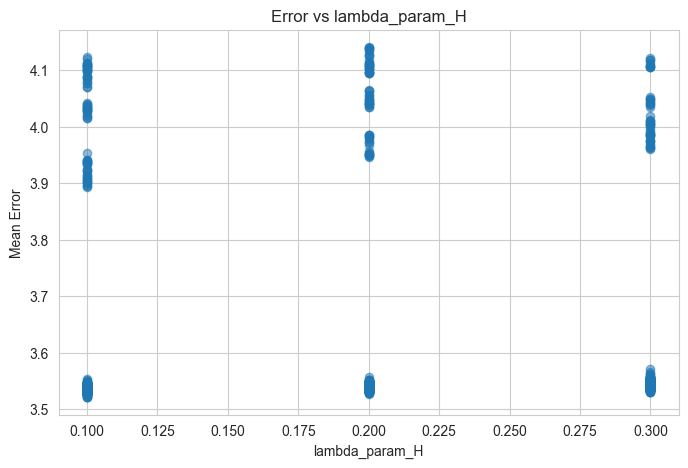

In [266]:
# Plot results distribution
plt.figure(figsize=(10, 6))
errors = [r['mean_error'] for r in results]
plt.hist(errors, bins=100)
plt.title('Distribution of Mean Errors Across Parameter Combinations')
plt.xlabel('Mean Error')
plt.ylabel('Count')
plt.show()

# Plot parameter importance
for param in param_grid.keys():
    plt.figure(figsize=(8, 5))
    param_values = [r['parameters'][param] for r in results]
    param_errors = [r['mean_error'] for r in results]
    plt.scatter(param_values, param_errors, alpha=0.5)
    plt.title(f'Error vs {param}')
    plt.xlabel(param)
    plt.ylabel('Mean Error')
    plt.show()

In [30]:
add_noiseL         = True
add_noiseH         = False
noise_typeL        = 'gelbrich_gaussian'
noise_typeH        = 'gelbrich_gaussian'

lin_contaminationL = False
lin_contaminationH = False
cont_type          = 'multiplicative'
cont_fracL         = .9
cont_fracH         = .6

metric             = 'wass'
num_iter           = 10

if noise_typeL == 'random_normal' or noise_typeH == 'random_normal':
    noise_range = (-2, 2)
else:
    noise_range = None

In [31]:
data = mut.load_samples(experiment)

100%|██████████| 10/10 [00:00<00:00, 14.59it/s]


Average abstraction error: 4.3437 ± 0.5022



100%|██████████| 10/10 [00:00<00:00, 15.49it/s]


Average abstraction error: 4.1177 ± 0.3421



100%|██████████| 10/10 [00:00<00:00, 15.72it/s]


Average abstraction error: 4.3238 ± 0.5806



100%|██████████| 10/10 [00:00<00:00, 15.80it/s]


Average abstraction error: 4.0783 ± 0.5224



100%|██████████| 10/10 [00:00<00:00, 15.97it/s]


Average abstraction error: 4.1797 ± 0.4697



100%|██████████| 10/10 [00:00<00:00, 15.96it/s]


Average abstraction error: 4.1741 ± 0.5644



100%|██████████| 10/10 [00:00<00:00, 14.21it/s]


Average abstraction error: 4.2827 ± 0.4502



100%|██████████| 10/10 [00:00<00:00, 15.55it/s]


Average abstraction error: 4.2361 ± 0.4496



100%|██████████| 10/10 [00:00<00:00, 16.44it/s]


Average abstraction error: 4.4257 ± 0.9186



100%|██████████| 10/10 [00:00<00:00, 14.14it/s]


Average abstraction error: 4.2827 ± 0.5562



100%|██████████| 10/10 [00:00<00:00, 11.62it/s]


Average abstraction error: 4.3646 ± 0.5118



100%|██████████| 10/10 [00:00<00:00, 16.45it/s]


Average abstraction error: 4.1942 ± 0.3544



100%|██████████| 10/10 [00:00<00:00, 16.35it/s]


Average abstraction error: 4.2463 ± 0.7301



100%|██████████| 10/10 [00:00<00:00, 16.08it/s]


Average abstraction error: 4.1573 ± 0.3918



100%|██████████| 10/10 [00:00<00:00, 15.77it/s]


Average abstraction error: 4.3282 ± 0.6375



100%|██████████| 10/10 [00:00<00:00, 16.41it/s]


Average abstraction error: 4.1735 ± 0.6977



100%|██████████| 10/10 [00:00<00:00, 15.66it/s]


Average abstraction error: 4.2757 ± 0.3919



100%|██████████| 10/10 [00:00<00:00, 16.17it/s]


Average abstraction error: 4.2789 ± 0.5629



100%|██████████| 10/10 [00:00<00:00, 15.48it/s]


Average abstraction error: 4.1897 ± 0.3424



100%|██████████| 10/10 [00:00<00:00, 14.82it/s]


Average abstraction error: 4.2101 ± 0.7292



100%|██████████| 10/10 [00:00<00:00, 14.15it/s]


Average abstraction error: 4.2627 ± 0.6021



100%|██████████| 10/10 [00:00<00:00, 15.75it/s]


Average abstraction error: 4.0311 ± 0.5943



100%|██████████| 10/10 [00:00<00:00, 14.53it/s]


Average abstraction error: 4.3319 ± 0.4528



100%|██████████| 10/10 [00:00<00:00, 15.13it/s]


Average abstraction error: 4.2615 ± 0.3892



100%|██████████| 10/10 [00:00<00:00, 16.25it/s]


Average abstraction error: 4.2740 ± 0.4877



100%|██████████| 10/10 [00:00<00:00, 16.33it/s]


Average abstraction error: 4.3902 ± 0.4312



100%|██████████| 10/10 [00:00<00:00, 16.17it/s]


Average abstraction error: 4.3283 ± 0.5939



100%|██████████| 10/10 [00:00<00:00, 16.40it/s]


Average abstraction error: 4.1783 ± 0.5809



100%|██████████| 10/10 [00:00<00:00, 16.50it/s]


Average abstraction error: 4.3589 ± 0.5358



100%|██████████| 10/10 [00:00<00:00, 16.29it/s]


Average abstraction error: 4.2480 ± 0.6226



100%|██████████| 10/10 [00:00<00:00, 16.40it/s]


Average abstraction error: 4.3897 ± 0.7319



100%|██████████| 10/10 [00:00<00:00, 16.11it/s]


Average abstraction error: 4.2506 ± 0.6362



100%|██████████| 10/10 [00:00<00:00, 14.06it/s]


Average abstraction error: 4.1611 ± 0.4501



100%|██████████| 10/10 [00:00<00:00, 16.40it/s]


Average abstraction error: 4.4535 ± 0.7887



100%|██████████| 10/10 [00:00<00:00, 14.75it/s]


Average abstraction error: 4.4045 ± 0.5025



100%|██████████| 10/10 [00:00<00:00, 13.18it/s]


Average abstraction error: 4.2769 ± 0.3592



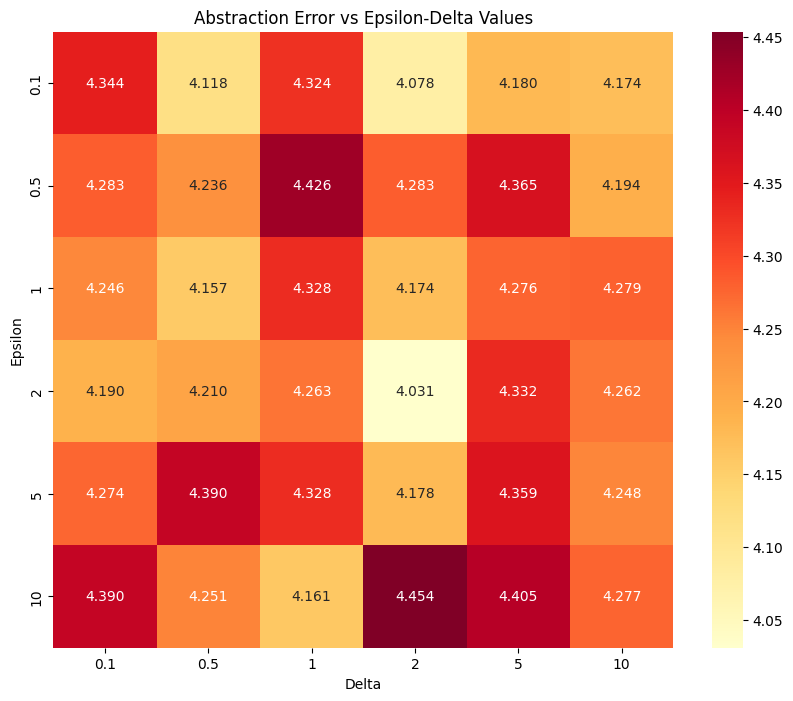

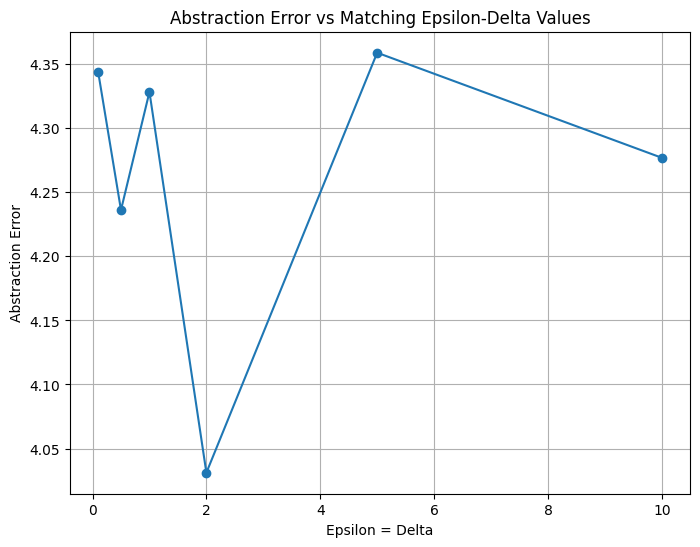


Best parameter combination:
Epsilon: 2, Delta: 2
Mean error: 4.0311 ± 0.5943


In [32]:
# Test increasing values of epsilon and delta together
epsilons_deltas = [.1, .5, 1, 2, 5, 10]  # Test matching pairs of epsilon/delta values
errors = np.zeros((len(epsilons_deltas), len(epsilons_deltas)))  # Initialize error storage matrix
results = []  # Store detailed results

for i, epsilon in enumerate(epsilons_deltas):
    for j, delta in enumerate(epsilons_deltas):
        
        # Evaluate abstraction error
        abstraction_error = []
        for _ in tqdm(range(num_iter)):
            noiseL = evut.generate_noise(data[None][0], noise_typeL, 'L', experiment, normalize=False, random_range=noise_range, rad=epsilon)
            noiseH = evut.generate_noise(data[None][1], noise_typeH, 'H', experiment, normalize=False, random_range=noise_range, rad=delta)
            
            total = 0
            for iota in Ill:
                base, abst = data[iota]
                if add_noiseL:
                    base = base + noiseL
                if add_noiseH:
                    abst = abst + noiseH
                    
                total += evut.compute_abstraction_error(T_erica_prox, base, abst, metric)
                            
            iter_avg = total / len(Ill)
            abstraction_error.append(iter_avg)
        
        mean_error = np.mean(abstraction_error)
        std_error = np.std(abstraction_error)
        
        # Store the results
        errors[i,j] = mean_error  # Store in matrix for heatmap
        results.append({          # Store detailed results
            'epsilon': epsilon,
            'delta': delta,
            'mean_error': mean_error,
            'std_error': std_error,
            'confidence_interval': std_error * 1.96
        })
        
        print(f"Average abstraction error: {mean_error:.4f} ± {std_error*1.96:.4f}\n")

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(errors, 
            xticklabels=epsilons_deltas,
            yticklabels=epsilons_deltas,
            annot=True,
            fmt='.3f',
            cmap='YlOrRd')
plt.xlabel('Delta')
plt.ylabel('Epsilon')
plt.title('Abstraction Error vs Epsilon-Delta Values')
plt.show()

# Line plot for diagonal values (where epsilon = delta)
plt.figure(figsize=(8, 6))
diagonal_errors = [errors[i,i] for i in range(len(epsilons_deltas))]
plt.plot(epsilons_deltas, diagonal_errors, marker='o')
plt.xlabel('Epsilon = Delta')
plt.ylabel('Abstraction Error')
plt.title('Abstraction Error vs Matching Epsilon-Delta Values')
plt.grid(True)
plt.show()

# Optional: Save results
results_df = pd.DataFrame(results)
results_df.to_csv('epsilon_delta_results.csv', index=False)

# Print best combination
best_result = min(results, key=lambda x: x['mean_error'])
print("\nBest parameter combination:")
print(f"Epsilon: {best_result['epsilon']}, Delta: {best_result['delta']}")
print(f"Mean error: {best_result['mean_error']:.4f} ± {best_result['confidence_interval']:.4f}")

### Plot Gaussian shift effects

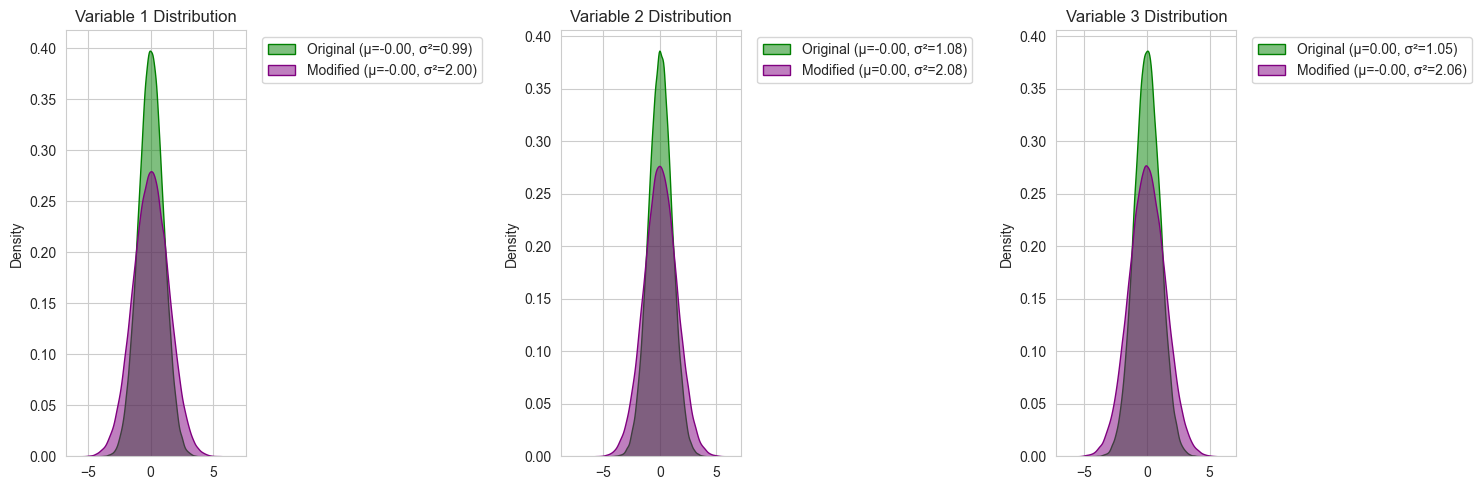

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],
/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


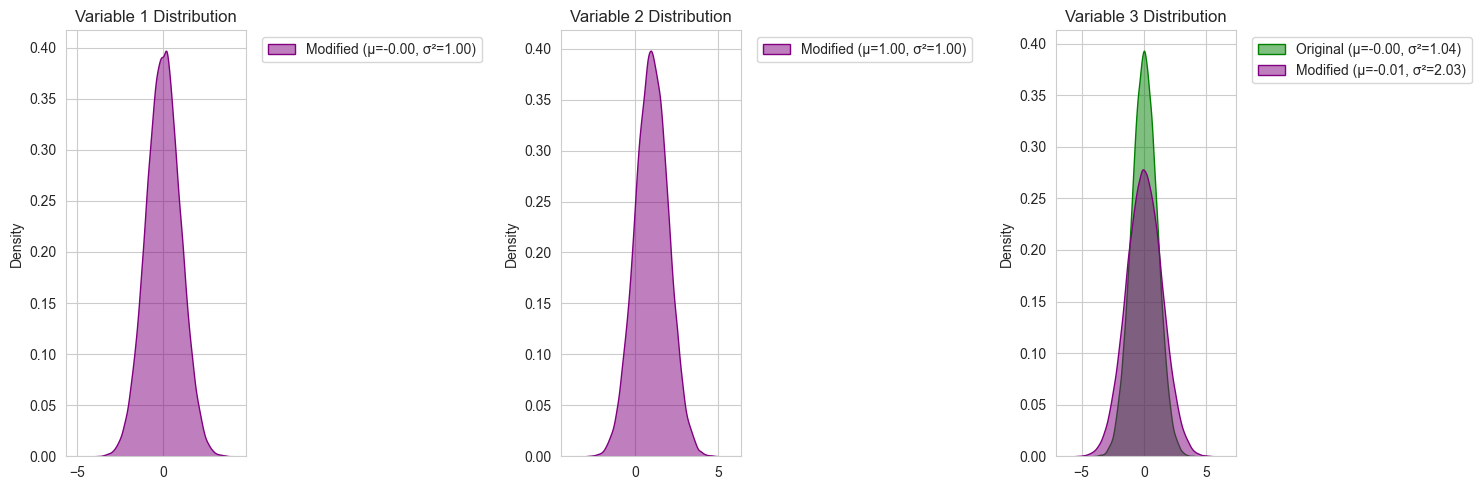

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


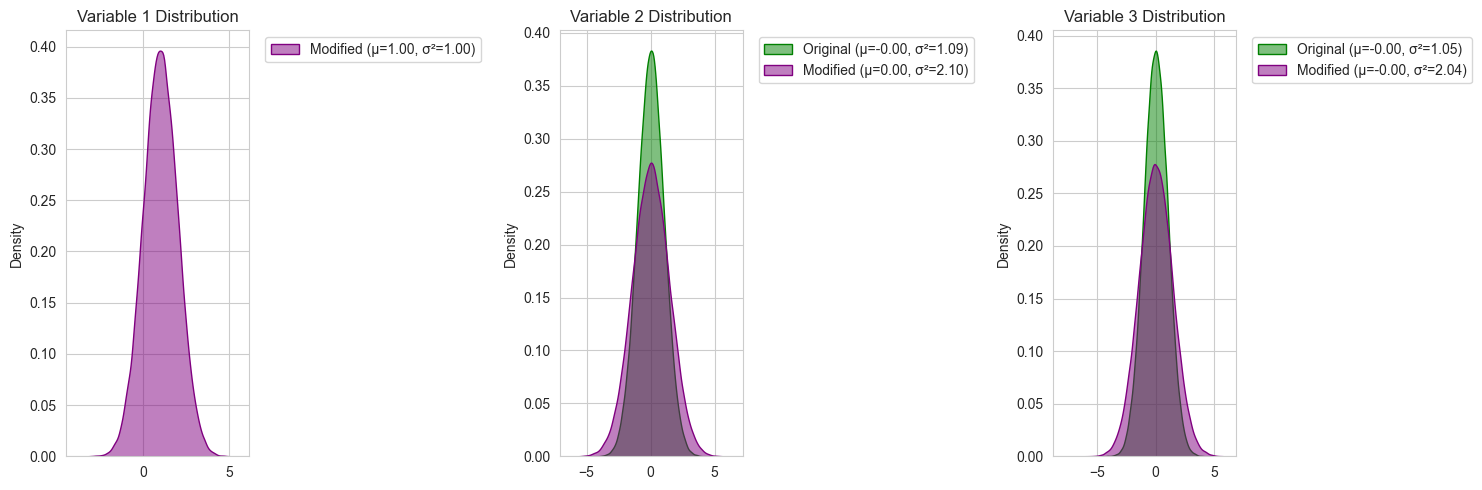

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


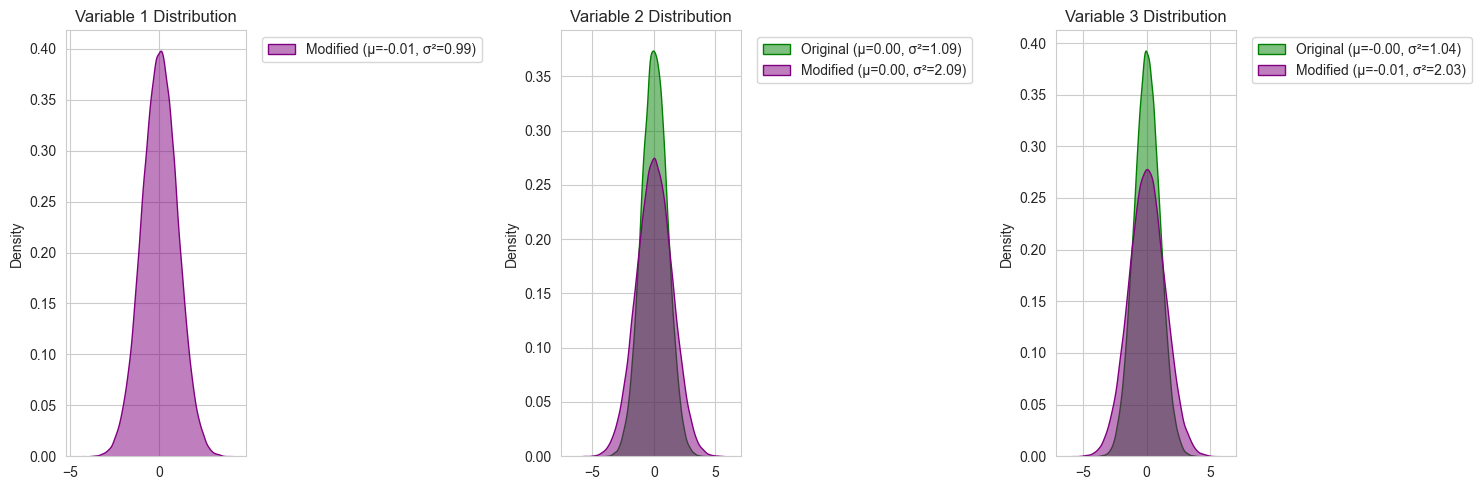

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],
/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


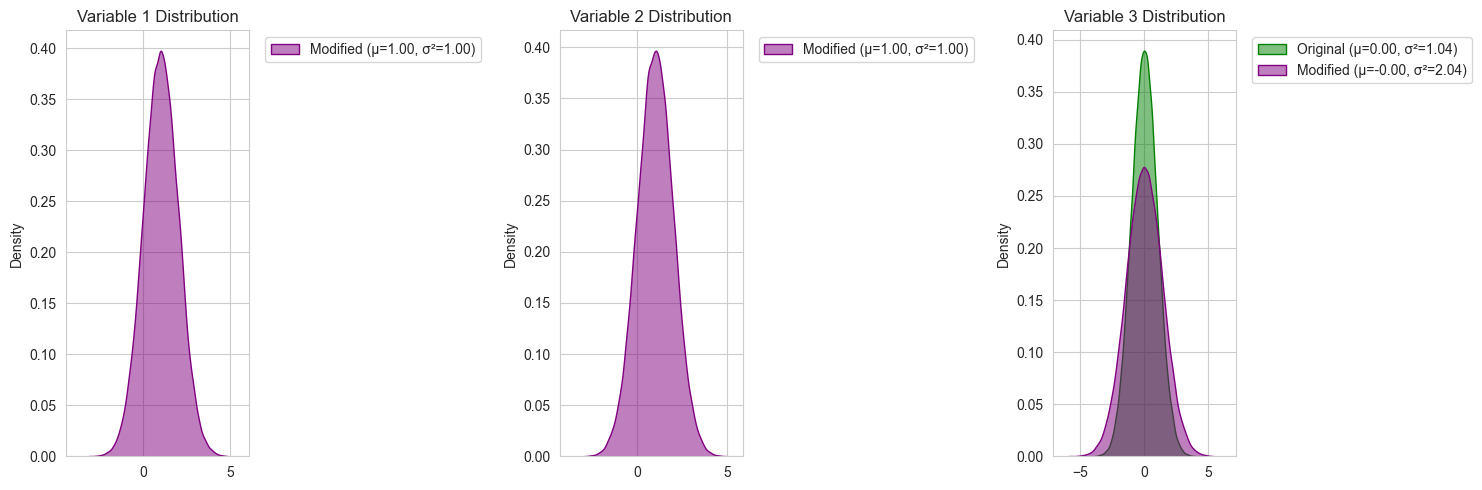

/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],
/Users/giofelekis/Desktop/ERiCA/evaluation_utils.py:169: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=original[:, i],


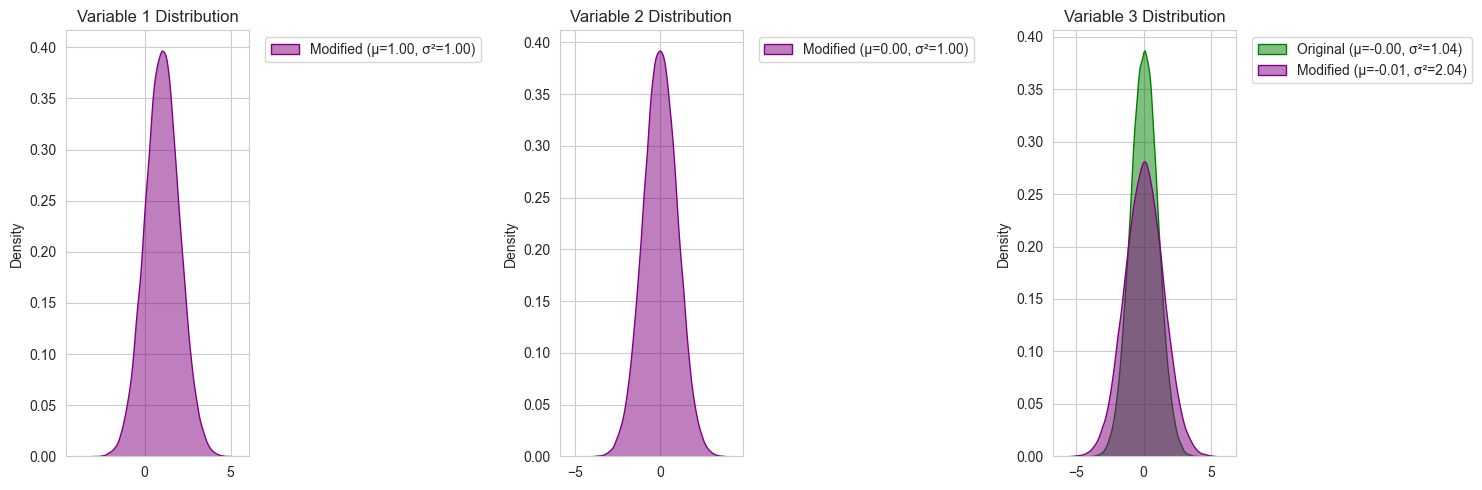

In [43]:
for iota in Ill:
    base, abst = data[iota]
    noisy_base = evut.add_random_noise(base, noise_typeL, 'L')
    evut.plot_distribution_shifts(base, noisy_base)#, f"Base Level Gaussian Shift - {noise_typeL}")
    print( )

### Plot Noise addition and linear contamination effects


In [37]:
for iota in Ill:
    base, abst = data[iota]
    #Add noise
    # base = evut.add_random_noise(base, noise_typeL, 'L')
    # abst = evut.add_random_noise(abst, noise_typeH, 'H')

    #Linear contamination
    base_c = evut.contaminate_linear_relationships(base, contamination_fraction=1, contamination_type='multiplicative')
    #abst_c = evut.contaminate_linear_relationships(abst, contamination_fraction=1, contamination_type='multiplicative')

    evut.plot_contamination_effects(base, base_c)
    print( )


## Structurally generated Gaussians (REVISE THIS!!)

In [79]:
for i, T in enumerate([T_erica, T_erica_prox, T_enrico, T_bary, T_bary_auto, Tau]): 
    all_errors = []  
    avg_error = 0
    
    for _ in range(num_iter):
        total = 0
        for iota in Ill:
            L_i = LLmodels[iota]._compute_reduced_form()
            V_i = T @ L_i
            H_i = HLmodels[omega[iota]]._compute_reduced_form()
            muV    = V_i @ params_Lerica['mu_U']
            sigmaV = V_i @ params_Lerica['Sigma_U'] @ V_i.T
            muH    = H_i @ params_Herica['mu_U']
            sigmaH = H_i @ params_Herica['Sigma_U'] @ H_i.T

            dist = mut.compute_wasserstein(muV, sigmaV, muH, sigmaH)

            total += dist

        iter_avg_ = total/len(Ill)
        all_errors.append(iter_avg_)  
 
    mean_e = np.mean(all_errors)
    std_e  = np.std(all_errors)
    print(f"Average e(τ) for {T_name[i]}: {mean_e:.6f} ± {std_e*1.96:.5f}")  

Average e(τ) for T_erica: 0.747125 ± 0.00000
Average e(τ) for T_erica_prox: 0.183244 ± 0.00000
Average e(τ) for T_enrico: 0.908769 ± 0.00000
Average e(τ) for T_bary: 2.330599 ± 0.00000
Average e(τ) for T_bary_auto: 0.918511 ± 0.00000
Average e(τ) for UniEnv_T: 1.922595 ± 0.00000


In [ ]:
params_erica =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': epsilon,
                    'delta': delta,
                    'lambda_L': lambda_L,
                    'lambda_H': lambda_H,
                    'lambda_param_L': lambda_param_L,
                    'lambda_param_H': lambda_param_H,
                    'xavier': xavier, 
                    'project_onto_gelbrich': project_onto_gelbrich, 
                    'eta_max': eta_max,
                    'eta_min': eta_min,
                    'max_iter': max_iter,
                    'num_steps_min': num_steps_min,
                    'num_steps_max': num_steps_max,
                    'proximal_grad': proximal_grad,
                    'tol': tol,
                    'seed': seed,
                    'robust_L': robust_L,
                    'robust_H': robust_H,
                    'grad_clip': grad_clip,
                    'plot_steps': plot_steps,
                    'plot_epochs': plot_epochs,
                    'display_results': display_results
                }

In [77]:
for epsilon in [.5, 1, 5, 10]:
    for delta in [.5, 1, 5, 10]:
        print(f"Epsilon: {epsilon}, Delta: {delta}")
        params_erica =  {
                            'theta_hatL': theta_hatL,
                            'theta_hatH': theta_hatH,
                            'initial_theta': 'empirical',
                            'epsilon': epsilon,
                            'delta': delta,
                            'lambda_L': .9,
                            'lambda_H': .9,
                            'lambda_param_L': .3, 
                            'lambda_param_H': .3,
                            'xavier': False, #If xavier is true, we need to project onto the Gelbrich ball!
                            'project_onto_gelbrich': True,
                            'eta_max': 0.001,
                            'eta_min': 0.001,
                            'max_iter': 10,
                            'num_steps_min': 5,
                            'num_steps_max': 3,
                            'proximal_grad': True,
                            'tol': 1e-5,
                            'seed': seed,
                            'robust_L': True,
                            'robust_H': True,
                            'plot_steps': False,
                            'plot_epochs': False,
                            'display_results': False
                        }

        params_Lerica, params_Herica, T_erica_prox, inobjs, epobjs, condition_num_list = run_optimization(**params_erica)
        type_to_params = {
                     'gelbrich_gaussian': {
                           'L': theta_hatL,
                           'H': theta_hatH
                     },
                     
                     'boundary_gaussian': {
                           'L': params_Lerica,
                           'H': params_Herica
                     }
                 }

        joblib.dump(type_to_params, f"data/{experiment}/type_to_params.pkl")
        method_names      = ['ERiCA']
        methods           = [T_erica]
        abstraction_error = {name: [] for name in method_names}

        # Outer loop: number of noise sampling iterations
        for iter_num in tqdm(range(num_iter)): # desc="Noise sampling iterations"
            
            noiseL = evut.generate_noise(data[None][0], noise_typeL, 'L', experiment, normalize=False, random_range=noise_range)
            noiseH = evut.generate_noise(data[None][1], noise_typeH, 'H', experiment, normalize=False, random_range=noise_range)
            
            # For this noise iteration, evaluate each method
            for i, T in enumerate(methods):
                total = 0
                start_time = time.time()
            
                # Compute average error over Ill for this method
                for iota in Ill:
                    # Get base data and add noise
                    base, abst = data[iota]
                    
                    if add_noiseL:
                        base = base + noiseL # + base 
                    if add_noiseH:
                        abst = abst + noiseH # + abst
                        
                    if lin_contaminationL:
                        base = evut.contaminate_linear_relationships(base, contamination_fraction=cont_fracL, contamination_type=cont_type)
                    if lin_contaminationH:
                        abst = evut.contaminate_linear_relationships(abst, contamination_fraction=cont_fracH, contamination_type=cont_type)
                    
                    tau_base   = base @ T.T
                    tau_muL    = np.mean(tau_base, axis=0)
                    tau_sigmaL = np.cov(tau_base, rowvar=False)
                    muH        = np.mean(abst, axis=0)
                    sigmaH     = np.cov(abst, rowvar=False)
                    
                    if metric == 'wass':
                        dist = mut.compute_wasserstein(tau_muL, tau_sigmaL, muH, sigmaH)
                    else:  # metric == 'js'
                        dist = mut.compute_jensenshannon(tau_base, abst)
                        
                    total += dist
                    
                iter_avg = total / len(Ill)
                abstraction_error[method_names[i]].append(iter_avg)
            
        # Compute final statistics
        final_abstraction_error = {}
        for name in method_names:
            mean_e = np.mean(abstraction_error[name])
            std_e = np.std(abstraction_error[name])
            final_abstraction_error[name] = (mean_e, std_e * 1.96)
            print(f"Average e(τ) for {name}: {mean_e:.2f} ± {std_e:.3f}\n")

Epsilon: 0.5, Delta: 0.5


  0%|          | 0/10 [00:00<?, ?it/s]/var/folders/vn/9swzhgj513q7n9gd_4vsbd840000gn/T/ipykernel_45367/4025087366.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu_L    = torch.tensor(mu_L, requires_grad=True)
/var/folders/vn/9swzhgj513q7n9gd_4vsbd840000gn/T/ipykernel_45367/4025087366.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu_H    = torch.tensor(mu_H, requires_grad=True)
/var/folders/vn/9swzhgj513q7n9gd_4vsbd840000gn/T/ipykernel_45367/4025087366.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Sigma_L = torch.tensor(S

Average e(τ) for ERiCA: 4.71 ± 0.014

Epsilon: 0.5, Delta: 1


100%|██████████| 10/10 [00:00<00:00, 16.73it/s]


Average e(τ) for ERiCA: 4.71 ± 0.011

Epsilon: 0.5, Delta: 5


100%|██████████| 10/10 [00:00<00:00, 16.43it/s]


Average e(τ) for ERiCA: 4.71 ± 0.015

Epsilon: 0.5, Delta: 10


100%|██████████| 10/10 [00:00<00:00, 15.57it/s]


Average e(τ) for ERiCA: 4.71 ± 0.013

Epsilon: 1, Delta: 0.5


100%|██████████| 10/10 [00:00<00:00, 14.10it/s]


Average e(τ) for ERiCA: 4.71 ± 0.018

Epsilon: 1, Delta: 1


100%|██████████| 10/10 [00:00<00:00, 16.11it/s]


Average e(τ) for ERiCA: 4.71 ± 0.015

Epsilon: 1, Delta: 5


100%|██████████| 10/10 [00:00<00:00, 16.77it/s]


Average e(τ) for ERiCA: 4.70 ± 0.017

Epsilon: 1, Delta: 10


100%|██████████| 10/10 [00:00<00:00, 16.85it/s]


Average e(τ) for ERiCA: 4.71 ± 0.009

Epsilon: 5, Delta: 0.5


100%|██████████| 10/10 [00:00<00:00, 16.83it/s]


Average e(τ) for ERiCA: 4.71 ± 0.014

Epsilon: 5, Delta: 1


100%|██████████| 10/10 [00:00<00:00, 16.90it/s]


Average e(τ) for ERiCA: 4.71 ± 0.017

Epsilon: 5, Delta: 5


100%|██████████| 10/10 [00:00<00:00, 10.66it/s]


Average e(τ) for ERiCA: 4.71 ± 0.015

Epsilon: 5, Delta: 10


100%|██████████| 10/10 [00:00<00:00, 15.48it/s]


Average e(τ) for ERiCA: 4.71 ± 0.010

Epsilon: 10, Delta: 0.5


100%|██████████| 10/10 [00:00<00:00, 16.27it/s]


Average e(τ) for ERiCA: 4.71 ± 0.014

Epsilon: 10, Delta: 1


100%|██████████| 10/10 [00:00<00:00, 15.54it/s]


Average e(τ) for ERiCA: 4.71 ± 0.012

Epsilon: 10, Delta: 5


100%|██████████| 10/10 [00:00<00:00, 16.03it/s]


Average e(τ) for ERiCA: 4.71 ± 0.015

Epsilon: 10, Delta: 10


100%|██████████| 10/10 [00:00<00:00, 14.78it/s]

Average e(τ) for ERiCA: 4.71 ± 0.010

